Using 'DeepFashion' Dataset for Test Purposes: (Category and Attribute Prediction Benchmark)

- https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html


DISC2021 Image Similarity Dataset:
- https://sites.google.com/view/isc2021/dataset

**Given a picture, find most similar 3 pictures from the set**

**Techs used:**

**ALIGN** for Embeddings

**Qdrant** for VectorDB

*1- Set up the ALIGN model* 

In [4]:
from transformers import AlignProcessor, AlignModel
import torch
from PIL import Image

# Load the ALIGN model and processor
model = AlignModel.from_pretrained("kakaobrain/align-base")
processor = AlignProcessor.from_pretrained("kakaobrain/align-base")

# Function to get embeddings
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    return outputs.detach().numpy().flatten()

def get_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt")
    outputs = model.get_text_features(**inputs)
    return outputs.detach().numpy().flatten()

*2- Initialize QDRANT and set up the collection*

In [7]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

# Initialize Qdrant client
qdrant_client = QdrantClient(host='localhost', port=6333)

# Define collection name
collection_name = "image_collection"

# Ensure the collection exists
qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=rest.VectorParams(size=640, distance=rest.Distance.COSINE),  # Adjust size based on model output
)

/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_71296/2013922421.py:11: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

*3- Generate Embeddings and Index Data*

In [8]:
import os

# Load and preprocess images
def load_images(image_dir):
    images = []
    file_names = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file_names.append(filename)
            images.append(os.path.join(image_dir, filename))
    return images, file_names

# Get embeddings for images and store them in Qdrant
def index_images(image_dir):
    images, file_names = load_images(image_dir)
    for i, image_path in enumerate(images):
        embedding = get_image_embedding(image_path)
        qdrant_client.upsert(
            collection_name=collection_name,
            points=[
                rest.PointStruct(
                    id=i,
                    vector=embedding,
                    payload={"file_name": file_names[i]},
                )
            ],
        )

# Index your images
image_directory = "test_images_design_subset"  # Replace with your image directory path
index_images(image_directory)

print("Indexing complete.")

Indexing complete.


*4- Query Data for Similarity Search*

**Text Query**

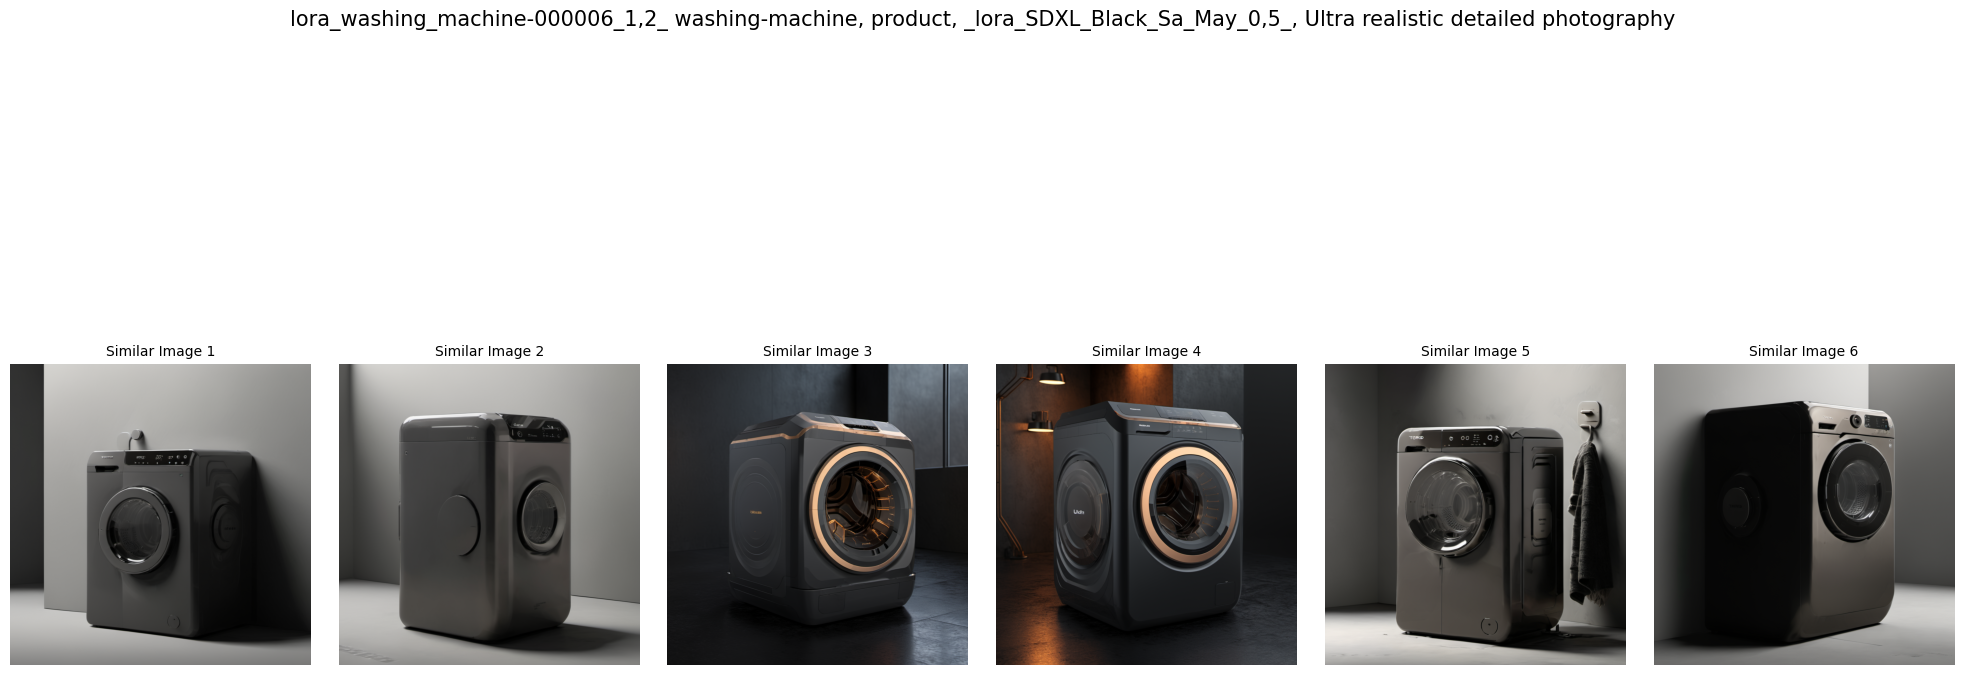

Similar images for text query: ['05248-design-3769663108-SDXL_base_1.0-_lora_pure_lora-000006_1_ pwre product, _lora_washing_machine-000006_0.3_ ,  _lora_FrostPunkAIv2_1.7_ frostpunkai, Ultra realist.png', '05245-design-3769663105-SDXL_base_1.0-_lora_pure_lora-000006_1_ pwre product, _lora_washing_machine-000006_0.3_ ,  _lora_FrostPunkAIv2_1.7_ frostpunkai, Ultra realist.png', '05174-design-212707336-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product , _lora_LuxTechAIv2_2_ luxtechai, _lora_arcelik_design_archive_captio.png', '05180-design-1667512602-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product , _lora_LuxTechAIv2_1.5_ luxtechai, _lora_arcelik_design_archive_capt.png', '05237-design-4018233610-SDXL_base_1.0-_lora_pure_lora-000006_1_ pwre product, _lora_washing_machine-000006_0.3_ ,  _lora_FrostPunkAIv2_2_ frostpunkai, Ultra realistic.png', '05243-design-2132340538-SDXL_base_1.0-_lora_pure_lora-000006_1_ pwre product, _lora_washing_machin

In [24]:
import matplotlib.pyplot as plt

def search_similar_images_text(query_text):
    query_embedding = get_text_embedding(query_text)
    
    search_result = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=6
    )
    
    similar_images = [hit.payload["file_name"] for hit in search_result]
    
    # Visualization
    fig, axes = plt.subplots(1, len(similar_images), figsize=(20, 10))
    # Display query text off the axes
    fig.suptitle(query_text, fontsize=15, ha='center')  # Set smaller font size and center text
    axes[0].axis("off")
    
    for i, img_name in enumerate(similar_images):
        img_path = os.path.join(image_directory, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Similar Image {i+1}", fontsize=10)
        axes[i].axis("off")
    

    plt.tight_layout(pad=2)  # Adjust padding to minimize white space
    plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust top and bottom to fit the suptitle and images
    plt.show()
    
    return similar_images

# Example text query
query_text = "lora_washing_machine-000006_1,2_ washing-machine, product, _lora_SDXL_Black_Sa_May_0,5_, Ultra realistic detailed photography"
similar_images = search_similar_images_text(query_text)
print("Similar images for text query:", similar_images)

**Image Query**

In [10]:
def search_similar_images_upload(image_path):
    query_embedding = get_image_embedding(image_path)
    
    search_result = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=6
    )
    
    similar_images = [hit.payload["file_name"] for hit in search_result]
    return similar_images

# Example image query
image_query_path = "test_images/design_test1.png"  # Replace with your image path
similar_images = search_similar_images_upload(image_query_path)
print("Similar images for uploaded image:", similar_images)

Similar images for uploaded image: ['05375-design-2179346598-juggernaut-_lora_washing_machine-000006_1,2_ washing-machine, product, _lora_SDXL_Black_Sa_May_0,5_, Ultra realistic detailed photography o.png', '05183-design-674731931-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product , , _lora_arcelik_design_archive_captioned_lora-000006_0.5_, Ultra re.png', '05186-design-2768218800-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product , , _lora_arcelik_design_archive_captioned_lora-000006_0.5_, _lora_HR.png', '05157-design-2162605923-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product , _lora_LuxTechAIv2_1_ luxtechai, _lora_arcelik_design_archive_captio.png', '05179-design-1667512601-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product , _lora_LuxTechAIv2_1.5_ luxtechai, _lora_arcelik_design_archive_capt.png', '05173-design-1468791812-SDXL_base_1.0-_lora_washing_machine-000006_0.5_ washing-machine, product 